In [ ]:
# Import Libraries and Download NLTK Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk


nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, precision_score, 
                             recall_score, f1_score)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ORS\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ORS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Load and Inspect the Dataset
df = pd.read_csv('Tweets.csv')
print(df.head())


             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnar

In [15]:
print("Initial dataset shape:", df.shape)

Initial dataset shape: (14640, 15)


In [16]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In [ ]:
# Clean the Data

# Drop columns 
columns_to_drop = [
    'negativereason', 'negativereason_confidence',
    'airline_sentiment_gold', 'negativereason_gold',
    'tweet_coord', 'tweet_location', 'user_timezone'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Drop rows 
df.dropna(subset=['text', 'airline_sentiment'], inplace=True)

# Remove duplicates if any
df.drop_duplicates(inplace=True)

df = df[df['airline_sentiment'].isin(['negative', 'positive'])]

print("Dataset shape after cleaning and filtering:", df.shape)
print("\nRemaining columns:", df.columns.tolist())


Dataset shape after cleaning and filtering: (11469, 8)

Remaining columns: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'airline', 'name', 'retweet_count', 'text', 'tweet_created']


# EDA

C:\Users\ORS\AppData\Local\Temp\ipykernel_10032\3083133733.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment', data=df, palette='Set2')


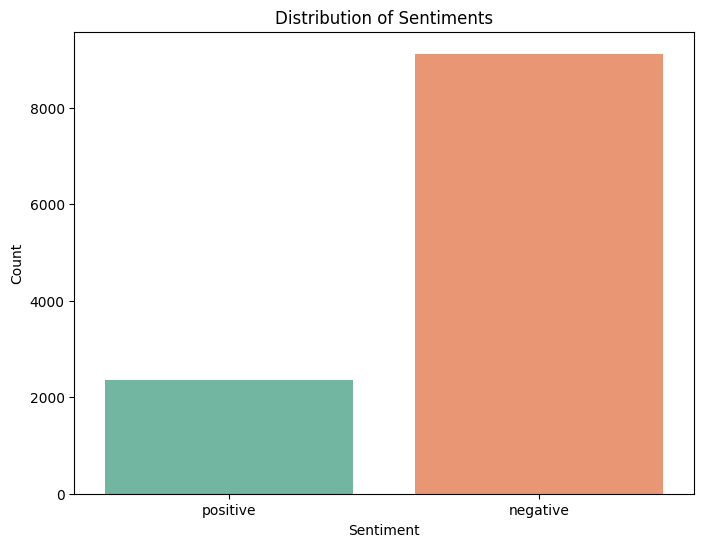

In [ ]:
# Distribution of Sentiments (Bar Chart)
plt.figure(figsize=(8,6))
sns.countplot(x='airline_sentiment', data=df, palette='Set2')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


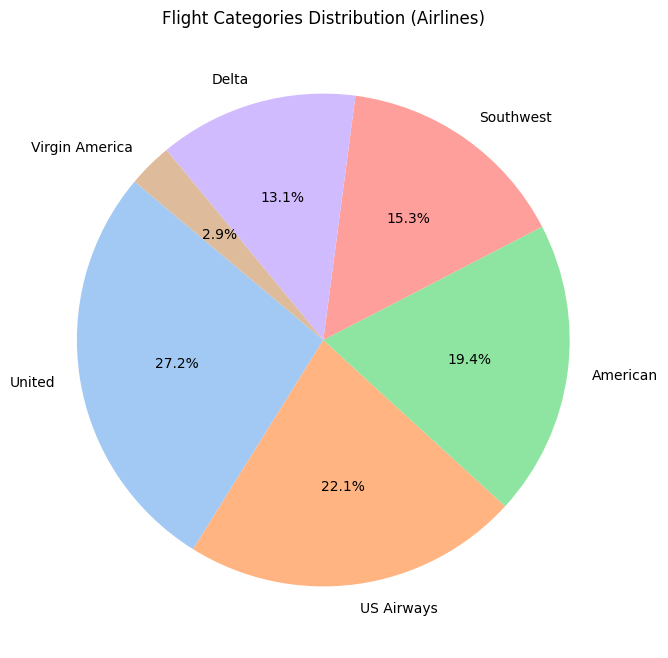

In [ ]:
# Flight Categories Pie Chart (Based on 'airline' column)
plt.figure(figsize=(8,8))
df['airline'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Flight Categories Distribution (Airlines)')
plt.ylabel('')
plt.show()

# Preprocesing

In [ ]:
#  Define Text Preprocessing Function (Only Lemmatization)
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions and hashtags
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuation and numbers (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Apply lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into a string
    return " ".join(tokens)

# Quick test of the function
sample_text = "This is a sample tweet! Check out http://example.com #example @user"
print("Processed sample text:", preprocess_text(sample_text))


Processed sample text: sample tweet check example


In [ ]:
#  Apply Preprocessing and Encode Sentiment
df['clean_text'] = df['text'].apply(preprocess_text)

# Map sentiment labels to numeric values: negative=0, positive=1
df['sentiment_label'] = df['airline_sentiment'].map({'negative': 0, 'positive': 1})

# Check distribution of sentiment labels
print("Sentiment label distribution:")
print(df['sentiment_label'].value_counts())
print(df[['text', 'clean_text', 'airline_sentiment', 'sentiment_label']].head())


Sentiment label distribution:
sentiment_label
0    9116
1    2353
Name: count, dtype: int64
                                                text  \
1  @VirginAmerica plus you've added commercials t...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   
5  @VirginAmerica seriously would pay $30 a fligh...   
6  @VirginAmerica yes, nearly every time I fly VX...   

                                          clean_text airline_sentiment  \
1       plus youve added commercial experience tacky          positive   
3  really aggressive blast obnoxious entertainmen...          negative   
4                               really big bad thing          negative   
5  seriously would pay flight seat didnt playing ...          negative   
6  yes nearly every time fly vx ear worm wont go ...          positive   

   sentiment_label  
1                1  
3                0  
4                0  
5                0  
6                1  


# Word cloud EDA

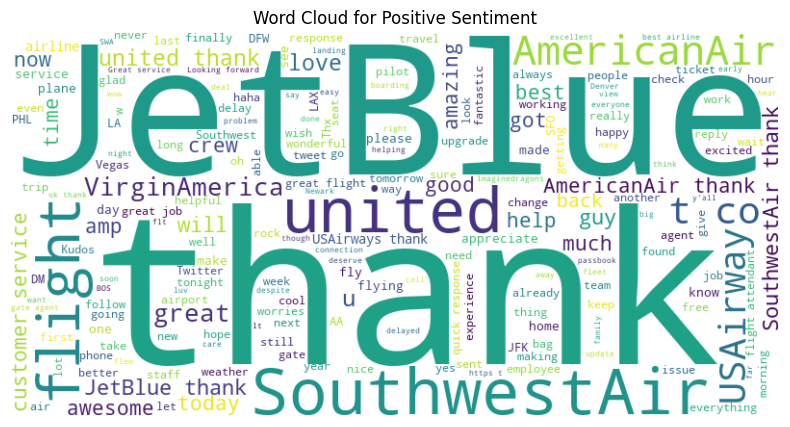

In [ ]:
#Word Cloud for Positive Sentiment
from wordcloud import WordCloud, STOPWORDS

positive_text = " ".join(df[df['airline_sentiment']=='positive']['text'])
wc_pos = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(positive_text)
plt.figure(figsize=(10,5))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment')
plt.show()

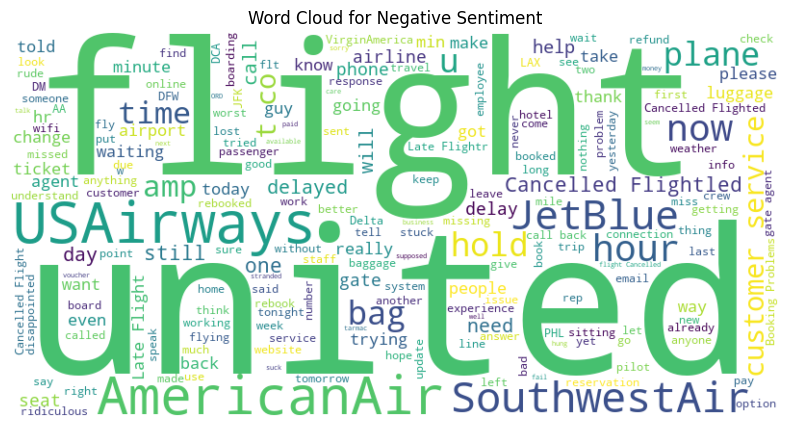

In [ ]:
# Word Cloud for Negative Sentiment
negative_text = " ".join(df[df['airline_sentiment']=='negative']['text'])
wc_neg = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(negative_text)
plt.figure(figsize=(10,5))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment')
plt.show()

In [ ]:
# Split Data for Random Forest Model
X_rf = df['clean_text'].values
y_rf = df['sentiment_label'].values

# Split into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42
)

# Convert text data to TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train_rf).toarray()
X_test_tfidf = tfidf.transform(X_test_rf).toarray()

print("TF-IDF Train Shape:", X_train_tfidf.shape)
print("TF-IDF Test Shape:", X_test_tfidf.shape)

# Compute class weights for imbalance handling
classes = np.unique(y_train_rf)
class_weights_rf = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_rf)
class_weight_dict_rf = dict(enumerate(class_weights_rf))
print("Class weights (Random Forest):", class_weight_dict_rf)


TF-IDF Train Shape: (9175, 5000)
TF-IDF Test Shape: (2294, 5000)
Class weights (Random Forest): {0: 0.6302376700096167, 1: 2.4195675105485233}


# Random Forest

Random Forest Accuracy: 0.9071490845684395
Random Forest Precision: 0.9037901072769788
Random Forest Recall: 0.9071490845684395
Random Forest F1 Score: 0.902623703865404

Classification Report (Random Forest):
              precision    recall  f1-score   support

    negative       0.92      0.97      0.94      1837
    positive       0.84      0.66      0.74       457

    accuracy                           0.91      2294
   macro avg       0.88      0.81      0.84      2294
weighted avg       0.90      0.91      0.90      2294



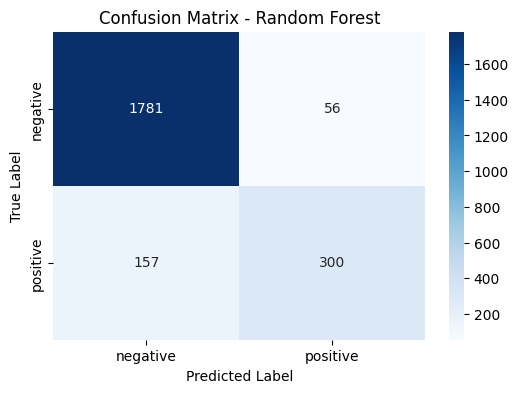

In [ ]:
# Train and Evaluate Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight=class_weight_dict_rf)
rf_model.fit(X_train_tfidf, y_train_rf)

# Predict on test data
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate Random Forest performance
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)
precision_rf = precision_score(y_test_rf, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test_rf, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test_rf, y_pred_rf, average='weighted')

print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Precision:", precision_rf)
print("Random Forest Recall:", recall_rf)
print("Random Forest F1 Score:", f1_rf)

# Classification report
print("\nClassification Report (Random Forest):")
print(classification_report(y_test_rf, y_pred_rf, target_names=['negative','positive']))

# Confusion Matrix
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest')
plt.show()


# LSTM

In [ ]:
# Prepare Data for LSTM Model
X_lstm = df['clean_text'].values
y_lstm = df['sentiment_label'].values

# Split into training and testing sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_lstm, y_lstm, test_size=0.2, random_state=42
)

# Tokenize text
max_num_words = 10000
tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(X_train_lstm)

X_train_seq = tokenizer.texts_to_sequences(X_train_lstm)
X_test_seq = tokenizer.texts_to_sequences(X_test_lstm)

# Pad sequences
max_seq_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)

# Convert labels to one-hot encoding for binary classification
num_classes = 2
y_train_cat = to_categorical(y_train_lstm, num_classes=num_classes)
y_test_cat = to_categorical(y_test_lstm, num_classes=num_classes)

print("LSTM Training data shape:", X_train_pad.shape)
print("LSTM Testing data shape:", X_test_pad.shape)

# Compute class weights for LSTM training
classes_lstm = np.unique(y_train_lstm)
class_weights_lstm = compute_class_weight(class_weight='balanced', classes=classes_lstm, y=y_train_lstm)
class_weight_dict_lstm = dict(enumerate(class_weights_lstm))
print("Class weights (LSTM):", class_weight_dict_lstm)


LSTM Training data shape: (9175, 100)
LSTM Testing data shape: (2294, 100)
Class weights (LSTM): {0: 0.6302376700096167, 1: 2.4195675105485233}


In [ ]:
# Build and Train Enhanced LSTM Model with Early Stopping and Class Weighting
embedding_dim = 200

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=max_num_words, 
                         output_dim=embedding_dim, 
                         input_length=max_seq_length))

lstm_model.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))

lstm_model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))

lstm_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

# EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the LSTM model using class weights
batch_size = 32
epochs = 10

history = lstm_model.fit(
    X_train_pad, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stop],
    class_weight=class_weight_dict_lstm
)




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          2000000   
                                                                 
 lstm (LSTM)                 (None, 100, 128)          168448    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 2300290 (8.77 MB)
Trainable params: 2300290 (8.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10


259/259 [==============================] - 157s 561ms/step - loss: 0.4119 - accuracy: 0.8162 - val_loss: 0.2624 - val_accuracy: 0.8900


72/72 [==============================] - 3s 47ms/step - loss: 0.2567 - accuracy: 0.9093
LSTM Test Loss: 0.2566876709461212
LSTM Test Accuracy: 0.9093286991119385
72/72 [==============================] - 4s 47ms/step

Classification Report (LSTM):
              precision    recall  f1-score   support

    negative       0.96      0.93      0.94      1837
    positive       0.74      0.83      0.79       457

    accuracy                           0.91      2294
   macro avg       0.85      0.88      0.86      2294
weighted avg       0.91      0.91      0.91      2294



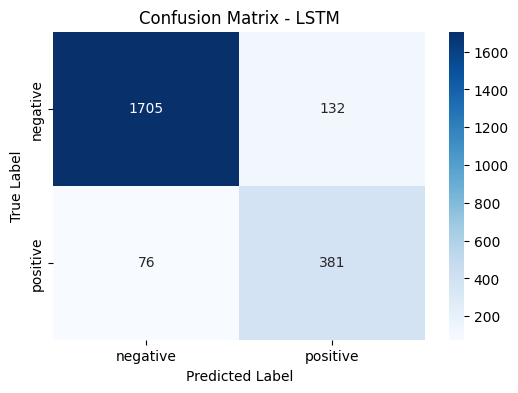

In [ ]:
#Evaluate LSTM Model and Plot Confusion Matrix
loss_lstm, accuracy_lstm = lstm_model.evaluate(X_test_pad, y_test_cat, verbose=1)
print("LSTM Test Loss:", loss_lstm)
print("LSTM Test Accuracy:", accuracy_lstm)

# Predict on test data
y_pred_lstm_prob = lstm_model.predict(X_test_pad)
y_pred_lstm = np.argmax(y_pred_lstm_prob, axis=1)
y_true_lstm = np.argmax(y_test_cat, axis=1)

# Compute additional metrics
precision_lstm = precision_score(y_true_lstm, y_pred_lstm, average='weighted')
recall_lstm = recall_score(y_true_lstm, y_pred_lstm, average='weighted')
f1_lstm = f1_score(y_true_lstm, y_pred_lstm, average='weighted')

print("\nClassification Report (LSTM):")
print(classification_report(y_true_lstm, y_pred_lstm, target_names=['negative','positive']))

# Plot confusion matrix
cm_lstm = confusion_matrix(y_true_lstm, y_pred_lstm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LSTM')
plt.show()


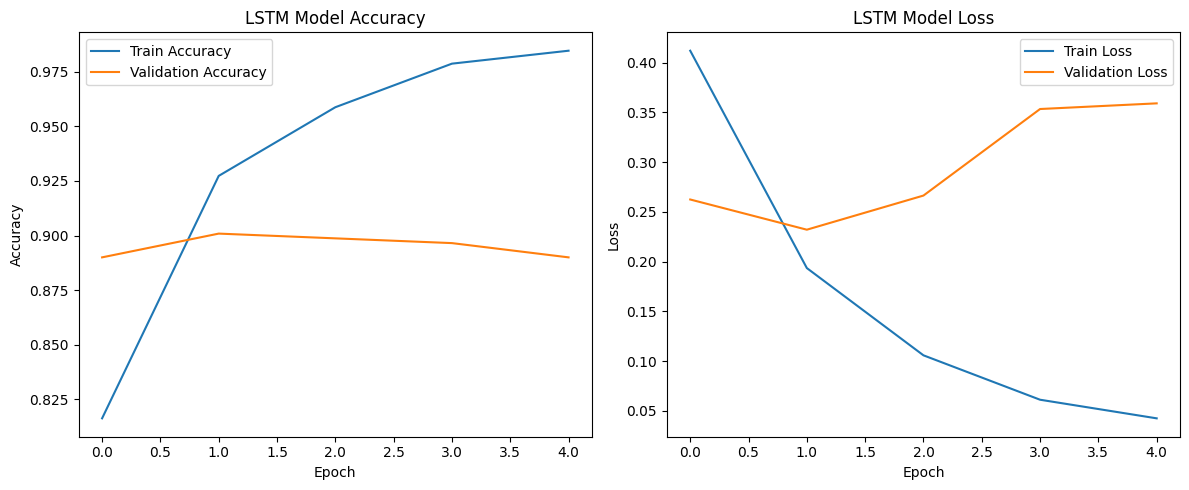

In [ ]:
# Plot LSTM Training History
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


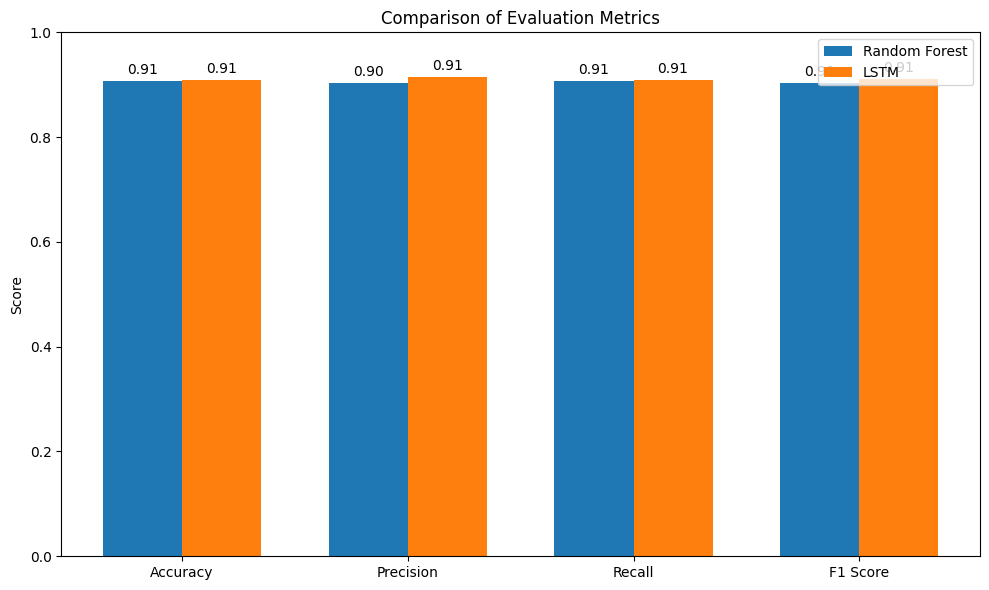


--- Final Model Comparison ---
Random Forest Metrics: {'Accuracy': 0.9071490845684395, 'Precision': 0.9037901072769788, 'Recall': 0.9071490845684395, 'F1 Score': 0.902623703865404}
LSTM Metrics: {'Accuracy': 0.9093286991119385, 'Precision': 0.9145683034000485, 'Recall': 0.909328683522232, 'F1 Score': 0.9112442870877171}


In [ ]:
# Compare Evaluation Metrics Between Random Forest and LSTM


rf_metrics = {
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1 Score': f1_rf
}


lstm_metrics = {
    'Accuracy': accuracy_lstm,
    'Precision': precision_lstm,
    'Recall': recall_lstm,
    'F1 Score': f1_lstm
}

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
rf_scores = [rf_metrics[m] for m in metrics]
lstm_scores = [lstm_metrics[m] for m in metrics]

x = np.arange(len(metrics))  # label locations
width = 0.35  # width of the bars

plt.figure(figsize=(10, 6))
rects1 = plt.bar(x - width/2, rf_scores, width, label='Random Forest')
rects2 = plt.bar(x + width/2, lstm_scores, width, label='LSTM')

plt.ylabel('Score')
plt.title('Comparison of Evaluation Metrics')
plt.xticks(x, metrics)
plt.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.2f}',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  # vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.ylim([0, 1])
plt.tight_layout()
plt.show()

print("\n--- Final Model Comparison ---")
print("Random Forest Metrics:", rf_metrics)
print("LSTM Metrics:", lstm_metrics)


In [ ]:
import pandas as pd

data = {
    'Model': ['Random Forest', 'LSTM'],
    'Accuracy': [accuracy_rf, accuracy_lstm],
    'Precision': [precision_rf, precision_lstm],
    'Recall': [recall_rf, recall_lstm],
    'F1 Score': [f1_rf, f1_lstm]
}

df_comparison = pd.DataFrame(data)

df_comparison[['Accuracy', 'Precision', 'Recall', 'F1 Score']] = df_comparison[['Accuracy', 'Precision', 'Recall', 'F1 Score']].round(4)

print("--- Final Model Comparison ---")
print(df_comparison)


--- Final Model Comparison ---
           Model  Accuracy  Precision  Recall  F1 Score
0  Random Forest    0.9071     0.9038  0.9071    0.9026
1           LSTM    0.9093     0.9146  0.9093    0.9112
